### Kaggle Link
https://www.kaggle.com/c/kkbox-churn-prediction-challenge

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

%matplotlib inline

In [2]:
parser = lambda x : pd.to_datetime(x, errors='coerce')

df_train = pd.read_csv('../Data/Kaggle/Churn/train.csv')
df_members = pd.read_csv('../Data/Kaggle/Churn/members.csv',
                         parse_dates=['registration_init_time', 'expiration_date'], date_parser=parser)
df_transactions = pd.read_csv('../Data/Kaggle/Churn/transactions.csv', 
                              parse_dates=['transaction_date', 'membership_expire_date'], date_parser=parser)
df_user_logs = pd.read_csv('../Data/Kaggle/Churn/user_logs.csv')

df_test = pd.read_csv('../Data/Kaggle/Churn/sample_submission_zero.csv')

KeyboardInterrupt: 

### Tables

##### train.csv: the train set, containing the user ids and whether they have churned.
    - msno: user id
    - is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.
    
##### user_logs.csv: daily user logs describing listening behaviors of a user. Data collected until 2/28/2017.
    - msno: user id
    - date: format %Y%m%d
    - num_25: # of songs played less than 25% of the song length
    - num_50: # of songs played between 25% to 50% of the song length
    - num_75: # of songs played between 50% to 75% of of the song length
    - num_985: # of songs played between 75% to 98.5% of the song length
    - num_100: # of songs played over 98.5% of the song length
    - num_unq: # of unique songs played
    - total_secs: total seconds played

##### transactions.csv: transactions of users up until 2/28/2017.
    - msno: user id
    - payment_method_id: payment method
    - payment_plan_days: length of membership plan in days
    - plan_list_price: in New Taiwan Dollar (NTD)
    - actual_amount_paid: in New Taiwan Dollar (NTD)
    - is_auto_renew
    - transaction_date: format %Y%m%d
    - membership_expire_date: format %Y%m%d
    - is_cancel: whether or not the user canceled the membership in this transaction.  
    
##### members.csv: user information. Note that not every user in the dataset is available.
    - msno
    - city
    - bd: age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.
    - gender
    - registered_via: registration method
    - registration_init_time: format %Y%m%d
    - expiration_date: format %Y%m%d

In [4]:
df_transactions = df_transactions.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)
df_transactions = df_transactions.drop_duplicates(subset=['msno'], keep='first')
df_transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,v9qq9up34ELNaGex7Yl0CvqwnRbh3qYgIu791AZN16s=,41,30,99,99,1,20170228,20170331,0
1,gxDtfzWgv9f2efeTFZfasyzjoO+xLwvrM501RcU8uZU=,40,30,149,149,1,20170228,20170327,0
2,wnanA7wQWo2kRKHJ+EAcAhllu7owvS3RbD7GvGUOWvY=,41,30,99,99,1,20170228,20170331,0
3,3+ECUXPd2GZYiniQMrRHzYLqQZ5LwsKYkrktEbGd4Wo=,41,30,99,99,1,20170228,20170331,0
4,OJwA/1avEFnk5nIWjSWmFYJU25o+Q+RMvaWiAXGKVQU=,41,30,99,99,1,20170228,20170331,0


### Merging

In [3]:
df_train = df_train.merge(df_members, how = 'left', on=['msno'])
df_train.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,expiration_date
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18.0,36.0,female,9.0,20050406.0,20170907.0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10.0,38.0,male,9.0,20050407.0,20170321.0
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11.0,27.0,female,9.0,20051016.0,20170203.0
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13.0,23.0,female,9.0,20051102.0,20170926.0
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3.0,27.0,male,9.0,20051228.0,20170927.0


In [5]:
df_train = df_train.merge(df_transactions, how='left', on=['msno'])

In [6]:
len(df_train)

992931

### Feature Engineering

In [ ]:
df_train['last_transaction_since_init'] = (df_train['transaction_date']-df_train['registration_init_time']).dt.days

### Exploratory Analysis

In [7]:
df_train['msno'].nunique()

992931

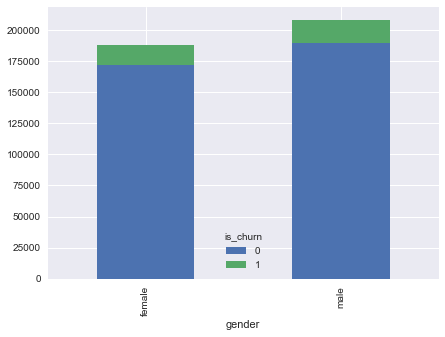

In [8]:
gender_crosstab = pd.crosstab(df_train['gender'],df_train['is_churn'])
gender_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(7, 5))

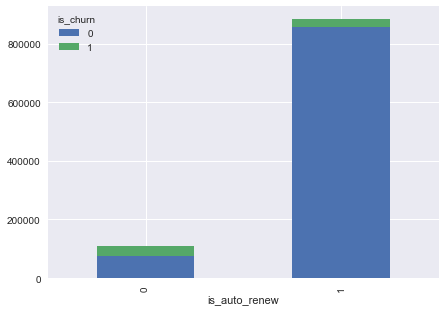

In [9]:
is_auto_renew_crosstab = pd.crosstab(df_train['is_auto_renew'],df_train['is_churn'])
is_auto_renew_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(7, 5))

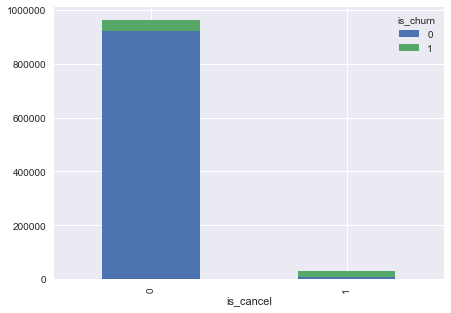

In [10]:
is_cancel_crosstab = pd.crosstab(df_train['is_cancel'],df_train['is_churn'])
is_cancel_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(7, 5))

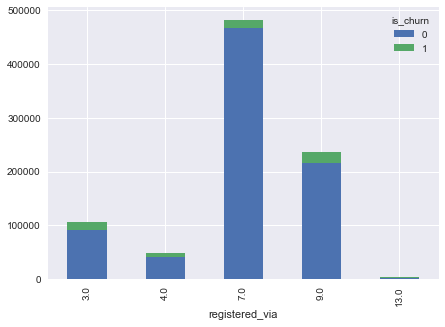

In [11]:
registered_via_crosstab = pd.crosstab(df_train['registered_via'],df_train['is_churn'])
registered_via_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(7, 5))

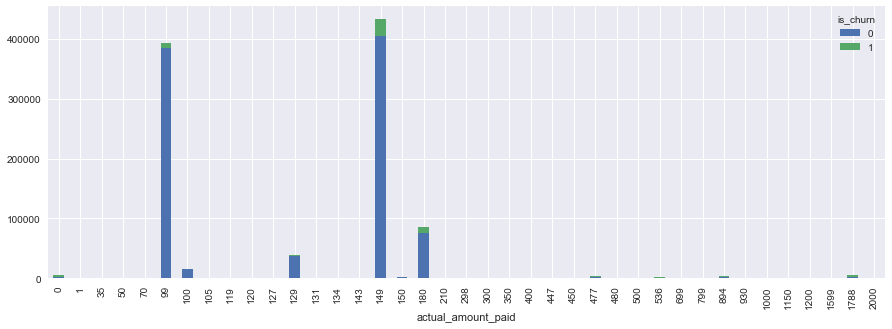

In [12]:
actual_amount_paid_crosstab=pd.crosstab(df_train['actual_amount_paid'],df_train['is_churn'])
actual_amount_paid_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

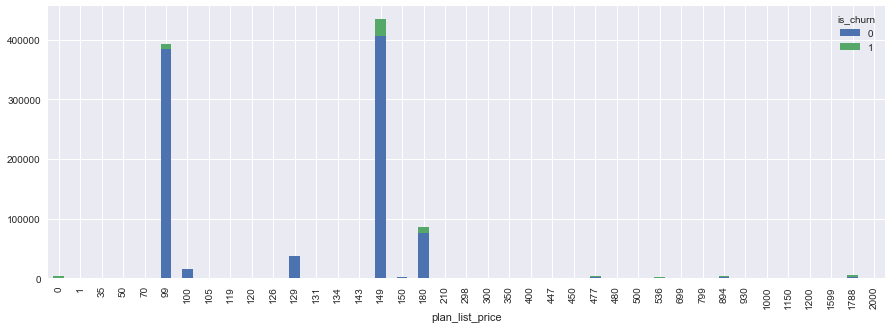

In [13]:
plan_list_price_crosstab=pd.crosstab(df_train['plan_list_price'],df_train['is_churn'])
plan_list_price_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

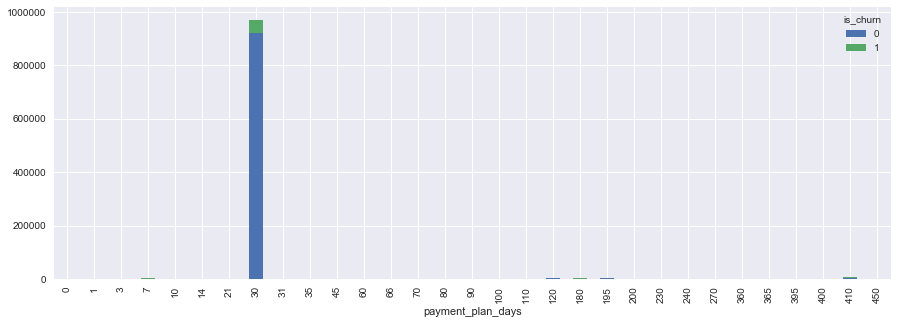

In [14]:
payment_plan_days_crosstab=pd.crosstab(df_train['payment_plan_days'],df_train['is_churn'])
payment_plan_days_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

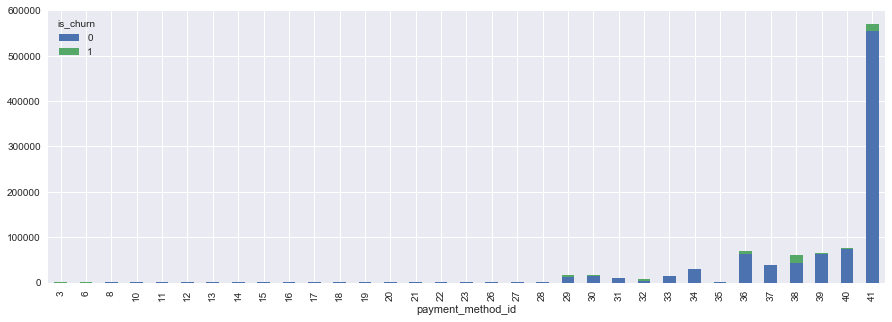

In [15]:
payment_method_id_crosstab=pd.crosstab(df_train['payment_method_id'],df_train['is_churn'])
payment_method_id_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

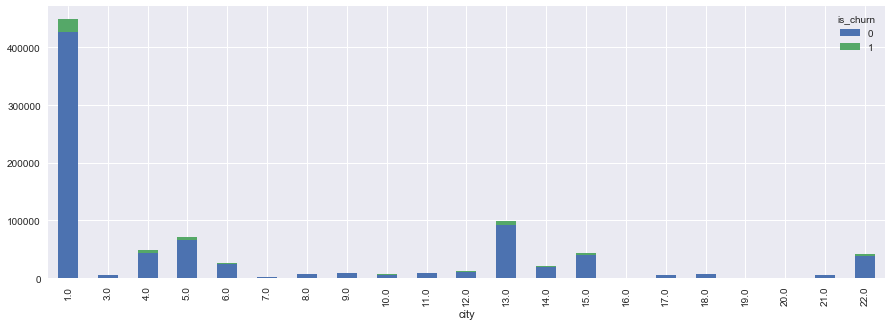

In [16]:
city_crosstab=pd.crosstab(df_train['city'],df_train['is_churn'])
city_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

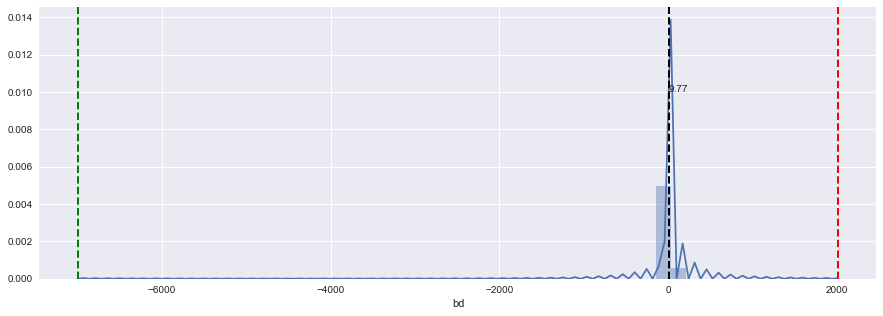

In [17]:
plt.figure(figsize=(15, 5))
sns.distplot(df_members['bd'], rug=False)
plt.axvline(df_members['bd'].min(),  color='g', linestyle='dashed', linewidth=2)
plt.axvline(df_members['bd'].max(),  color='r', linestyle='dashed', linewidth=2)
h = df_members['bd'].mean()
plt.axvline(h, color='k', linestyle='dashed', linewidth=2)
plt.annotate('{0:.2f}'.format(h),xy=(h+0.5, 0.01))

### Dealing with NaNs

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 992931 entries, 0 to 992930
Data columns (total 16 columns):
msno                      992931 non-null object
is_churn                  992931 non-null int64
city                      876143 non-null float64
bd                        876143 non-null float64
gender                    396057 non-null object
registered_via            876143 non-null float64
registration_init_time    876143 non-null float64
expiration_date           876143 non-null float64
payment_method_id         992931 non-null int64
payment_plan_days         992931 non-null int64
plan_list_price           992931 non-null int64
actual_amount_paid        992931 non-null int64
is_auto_renew             992931 non-null int64
transaction_date          992931 non-null int64
membership_expire_date    992931 non-null int64
is_cancel                 992931 non-null int64
dtypes: float64(5), int64(9), object(2)
memory usage: 128.8+ MB


In [19]:
df_train.drop(['gender'], axis=1, inplace=True)

In [20]:
df_train.dropna(inplace=True)

### Modeling

In [21]:
df_train.drop(['msno', 'transaction_date', 'membership_expire_date', 'expiration_date'], axis=1, inplace=True)

In [22]:
df_train.head()

,is_churn,city,bd,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel
0,1,18.0,36.0,9.0,20050406.0,38,30,149,149,0,0
1,1,10.0,38.0,9.0,20050407.0,39,30,149,149,1,1
2,1,11.0,27.0,9.0,20051016.0,39,30,149,149,1,1
3,1,13.0,23.0,9.0,20051102.0,38,410,1788,1788,0,0
4,1,3.0,27.0,9.0,20051228.0,38,30,149,149,0,0


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [24]:
X_train = df_train.drop(['is_churn'], axis=1)
y_train = df_train['is_churn']

#### XGBoost

In [ ]:
import xgboost as xgb

from sklearn.grid_search import GridSearchCV

C:\Users\paula.ceccon.ribeiro\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\paula.ceccon.ribeiro\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [ ]:
model = xgb.XGBClassifier(silent=1)
model_params = {
    'n_estimators':       [50, 100, 200, 300],
    'learning_rate':      [0.05, 0.1, 0.5],
    'max_depth':          [2, 3, 5, 10],
    'min_child_weight':   [1, 3, 5, 7],
    'subsample':          [0.3, 0.5, 0.8, 1.0],
    'colsample_bytree':   [0.3, 0.5, 0.7, 1.0],
    'colsample_bylevel':  [0.5, 0.7, 1.0]
}

grid = GridSearchCV(model, model_params, scoring='neg_log_loss', cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print (grid.best_params_)

Fitting 5 folds for each of 9216 candidates, totalling 46080 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min


In [ ]:
model = xgb.XGBClassifier(silent=1, grid.best_params_).fit(X_train, y_train)

In [ ]:
scores = cross_val_score(model, X_test, y_test, cv=5)
print("Log Loss: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))